# PreProcessing Demonstration

* **Last Modified**: 19-02-2021
* **Authors**: J. Emmanuel Johnson, Satyarth Praveen, Nadia Ahmed, Nicholas Roth
---
#### Brief Description

In this notebook, we will explore some ways that we can do *augmentations* that are necessary for machine learning purposes. The image data that we receive is not often ready for ML models. We often need to do further transformations to before we input them into our machine learning model. Augmentation serves a few purposes:

1. It makes our models more robust to augmentations that we may find in th real world.
2. It can potentially expand our training dataset more by including "augmented" data.

Often times this functionality is hidden within the code but in this notebook, we expose the user step-by-step for how they can reproduce some of the augmentations used within the WorldFloods dataset. We hope this will not only provide understanding and explainability, but also spark some future research purposes.

---
#### TLDR

> Augmentations are important are a crucial component of an ML pipeline. This notebook will demonstrate how we can do this for the WorldFloods Dataset in particular.

---

#### Note

If you haven't already ran the previous notebook titled `1.1_demo_pytorch_tiling_refactor`, then please do that **BEFORE** running this notebook.

---
#### More Information

* [PyTorch TorchVision Demo](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)


## Package Preamble

For starters, we want to import the necessary packages. We will outline which ones they are below and why we're using them.

In [1]:
# ====================================================
# Helpful trick for loading the directories correction
# ====================================================
from pathlib import Path
import sys, os
from pyprojroot import here
# spyder up to find the root
root = here(project_files=[".here"])
# append to path
sys.path.append(str(here()))

# ====================================================
# Utils for getting filenames and directories
# ====================================================
from src.data.utils import get_files_in_directory, get_filenames_in_directory

# ====================================================
# Imports for the transformations
# ====================================================

import src.preprocess.transformations as transformations
import albumentations
from torchvision import transforms as tvtransforms
from src.preprocess.worldfloods import normalize as wf_normalization
# ====================================================
# Standard Packages
# ====================================================
import numpy as np
import json

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Demo Images

First and foremost, we need a demo image database. For this one, we will be using the WorldFloods database which can be found [here](). 

We have already pretiled the transformations (see above to gather the images). As we can see, we already have some images already to go. Let's take a peek.

In [2]:
# outpur directory
output_image_dir = str(Path(root).joinpath("datasets/trials/image/image_tiles/"))
image_files = get_files_in_directory(output_image_dir, ".tif")

# show only a few image files
!ls $output_image_dir | head -4

01042016_Holmes_Creek_at_Vernon_FL_tile_0.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_1.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_10.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_100.tif


Now let's get all of the image file names in the output directory.

In [3]:
output_gt_dir = str(Path(root).joinpath("datasets/trials/image/gt_tiles/"))
gt_files = get_files_in_directory(output_gt_dir, ".tif")

# show only a few image files
!ls $output_gt_dir | head -4

01042016_Holmes_Creek_at_Vernon_FL_tile_0.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_1.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_10.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_100.tif


Notice how we seem to have the previously defined the path directory:

`/home/{user}/{other_path}/ml4floods/datasets/trials/image/image_tiles`

And the only difference between the location of the image files is the prefix changes from `/image_tiles/` to `/gt_tiles/`. This was done on purpose to ensure that our directory is simple and easy to understand. The images have the same name but they are differentiated by the *prefix*. So those are necessary for our dataloader because it explicitly tells us that we need to differentiate between the `image` and the `label` by the prefix `image_tiles` and `gt_tiles` respectively.

In [4]:
image_prefix = "image_tiles"
gt_prefix = "gt_tiles"

So now, we can initalize our predefined `WorldFloodsDataset` class.

In [5]:
from src.data.worldfloods.dataset import WorldFloodsDataset

# intialize worldfloods PyTorch Dataset
pt_ds = WorldFloodsDataset(
    image_files=image_files, 
    image_prefix=image_prefix,
    gt_prefix=gt_prefix
)

#### Nice Attributes

There are some nifty attributes available now that we have our Dataset. Firstly, we can get the length (number of images loaded) as well as explicitly extract the images via the index.

In [6]:
# get the length
n_images = len(pt_ds)
print(f"Number of Images: {n_images}")

# extract a demo image
demo_image = pt_ds[50]

# extract the image and mask
image, mask = demo_image["image"], demo_image["mask"]

print(f"Size: {image.shape}\nMask Size: {mask.shape}")

Number of Images: 330
Size: (13, 128, 128)
Mask Size: (1, 128, 128)


#### Note: Image Shapes

So noteice how the image shapes are `(Channel, Height, Width)`. This is the default pattern that rasterio outputs and also PyTorch. So we never change this unless this is absolutely necessary. We are heavily dependent upon `rasterio` and `pytorch` so we stick with this as the default. 

For other libraries like `scikit-image`, `pillow` and `matplotlib`, we use the `(height,width,channel)`. So for example, if we want to plot this, then we need to change the shape to accommadate the shape size.

(128, 128, 13) (128, 128, 1)


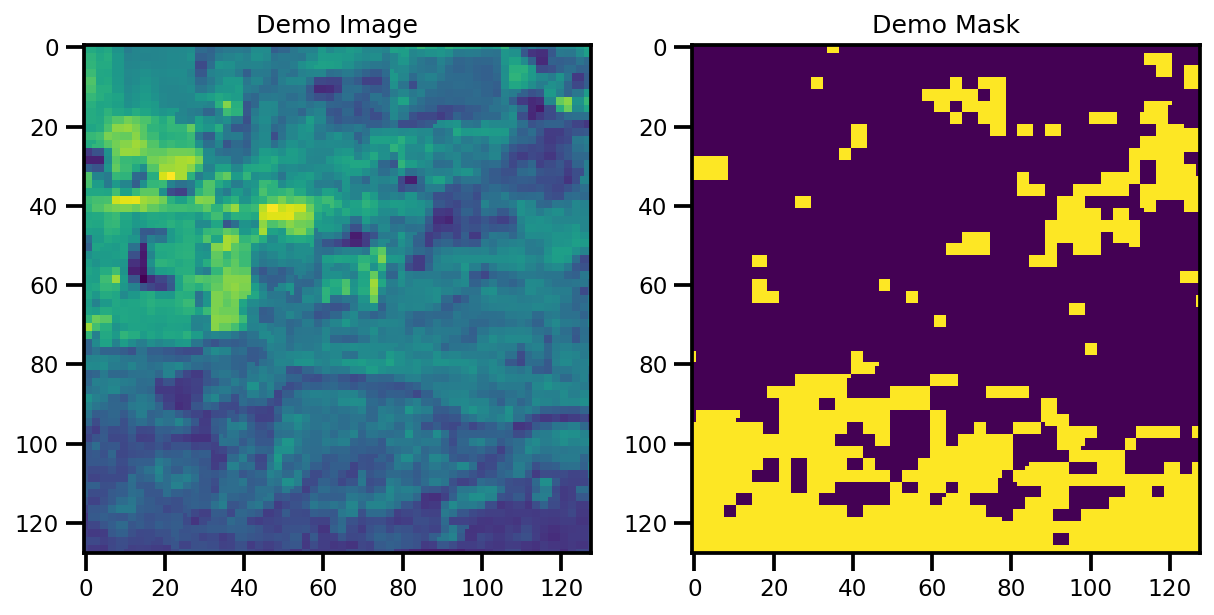

In [7]:
from rasterio.plot import reshape_as_image, show as plot_rasterio

def plot_images(demo_image_dict):
    
    image, mask = demo_image_dict["image"], demo_image_dict["mask"]
    # reshape as image
    plot_image = reshape_as_image(image)
    plot_mask = reshape_as_image(mask)
    print(plot_image.shape, plot_mask.shape)
    # demo plot
    fig, ax = plt.subplots(ncols=2, figsize=(10, 20))
    plot_rasterio(plot_image[:, :, 6], ax=ax[0])
    ax[0].set(title="Demo Image",)
    plot_rasterio(mask, ax=ax[1])
    ax[1].set(title="Demo Mask",)
    plt.show()
    
    
plot_images(pt_ds[50])

In [8]:
def plot_image_corner(demo_image_dict):
    
    image, mask = demo_image_dict["image"], demo_image_dict["mask"]
    # reshape as image
    plot_image = reshape_as_image(image)
    plot_mask = reshape_as_image(mask)
    print(plot_image.shape, plot_mask.shape)
    # demo plot
    fig, ax = plt.subplots(ncols=2, figsize=(10, 20))
    plot_rasterio(plot_image[:, :, 6], ax=ax[0])
    ax[0].set(title="Demo Image",)
    plot_rasterio(mask, ax=ax[1])
    ax[1].set(title="Demo Mask",)
    plt.show()
    

(3, 128, 128)


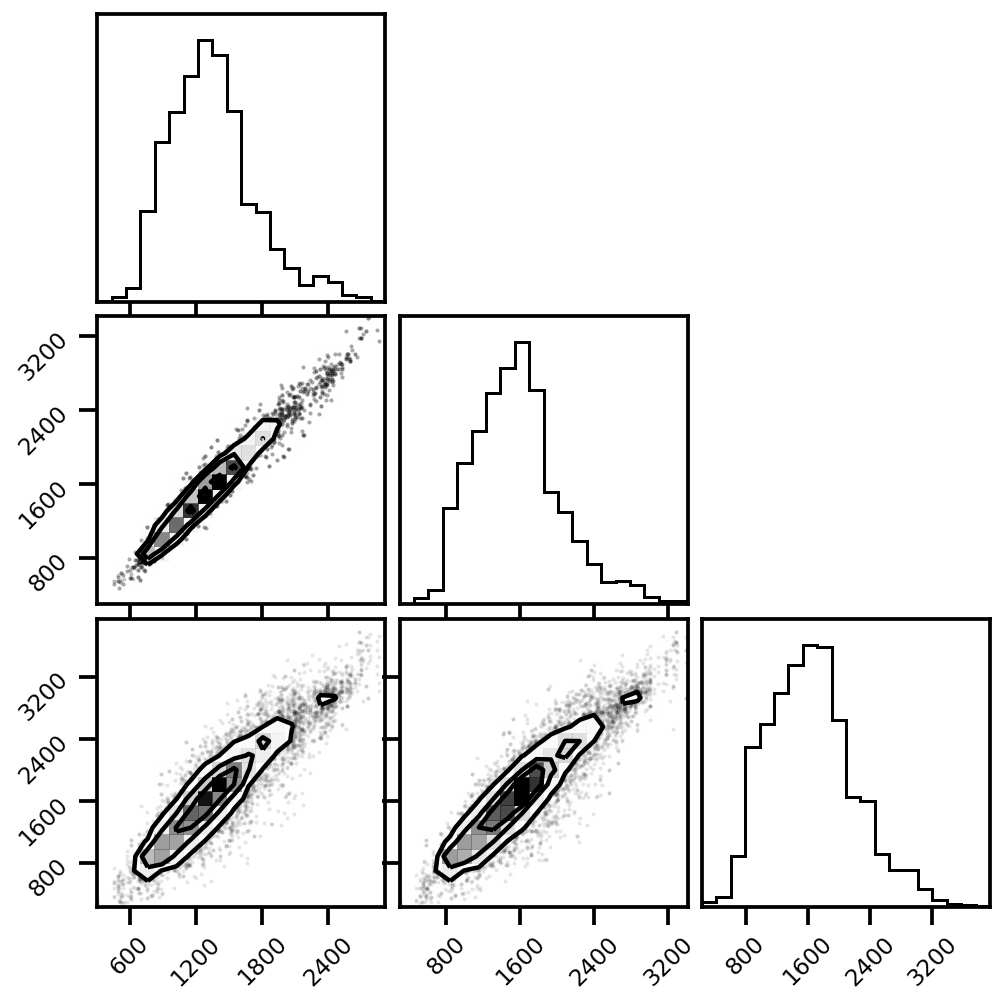

In [9]:
import corner

t = pt_ds[50]["image"][5:8]
print(t.shape)
t = reshape_as_image(t).reshape(t.shape[1]*t.shape[2], t.shape[0])

figure = corner.corner(t)

## Transformations

### Utility

---
#### Permute Channels

This is a simple permutation of the channels. In the case that the dataset was in a different order or we need to change the order, this transform would do the following:

$$
\text{Height}\times\text{Width}\times\text{Channels} \rightarrow \text{Channels}\times\text{Height}\times\text{Width} 
$$

Again, this is **mainly** for the other libraries.

In [10]:
transform_invpermutechannels = transformations.InversePermuteChannels()
transform_permutechannels = transformations.PermuteChannels()

pt_ds = WorldFloodsDataset(image_files, image_prefix, gt_prefix, transforms=transform_invpermutechannels)

print(f"Image (shape): {pt_ds[0]['image'].shape}")


mega_transform = albumentations.Compose([
    transform_invpermutechannels, 
    transform_permutechannels
    ])

pt_ds = WorldFloodsDataset(image_files, image_prefix, gt_prefix, transforms=mega_transform)

print(f"Image (shape): {pt_ds[0]['image'].shape}")

Image (shape): (128, 128, 13)
Image (shape): (13, 128, 128)


---
#### To Tensor

This transforms our types to a tensor. Typically this is the **last** transform that we do.

In [11]:
transform_totensor = transformations.ToTensor()

pt_ds = WorldFloodsDataset(image_files, image_prefix, gt_prefix, transforms=transform_totensor)

print(f"Image (type): {type(pt_ds[0]['image'])}")

Image (type): <class 'torch.Tensor'>


####  One Hot Encoding

In [12]:

transform_totensor = transformations.ToTensor()
transform_onehotencode = transformations.OneHotEncoding(num_classes=3)
mega_transform = albumentations.Compose([
    transform_totensor, 
    transform_onehotencode,
    ])

pt_ds = WorldFloodsDataset(image_files, image_prefix, gt_prefix, transforms=mega_transform)

print(f"Image (type): {pt_ds[0]['mask'].shape}")

Image (type): torch.Size([1, 128, 128, 3])


### Specialzed

#### Normalize

Image (type): (13, 128, 128)
(128, 128, 13) (128, 128, 1)


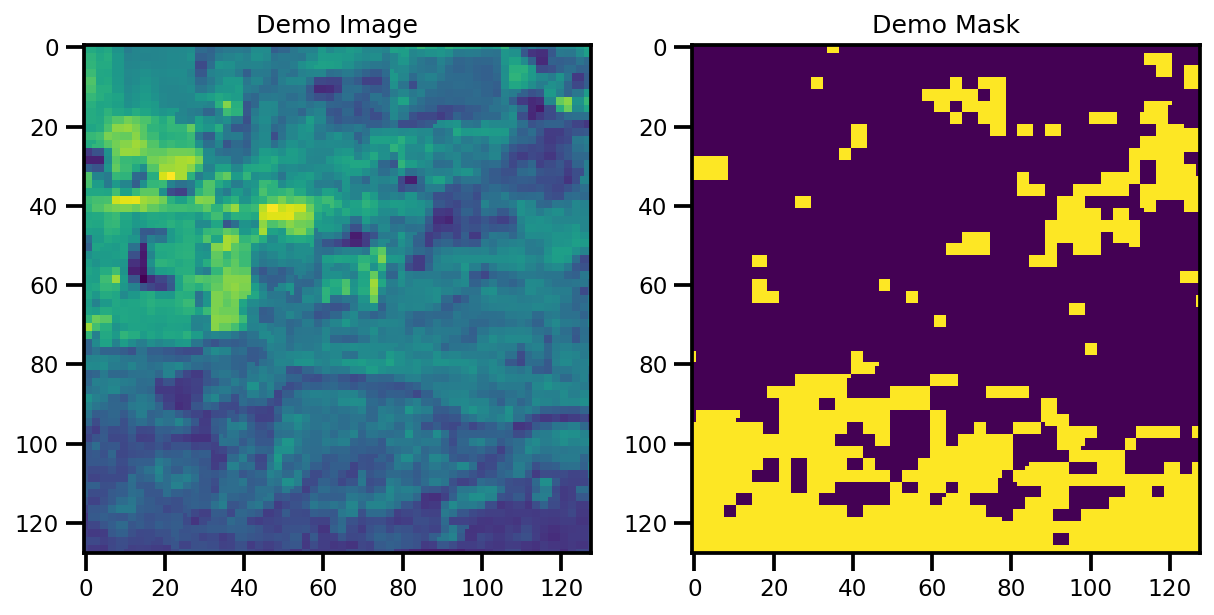

In [13]:

use_channels = "all"
channel_mean, channel_std = wf_normalization.get_normalisation(use_channels)
transform_normalize = transformations.Normalize(
    mean=0.0, 
    std=1.0, 
    max_pixel_value=100
)
transform_invpermutechannels = transformations.InversePermuteChannels()
transform_permutechannels = transformations.PermuteChannels()


mega_transform = albumentations.Compose([
    transform_invpermutechannels,
    transform_normalize,
    transform_permutechannels
    ])

pt_ds = WorldFloodsDataset(image_files, image_prefix, gt_prefix, transforms=mega_transform)

print(f"Image (type): {pt_ds[0]['image'].shape}")


plot_images(pt_ds[50])

#### ShiftScaleRotate (Per Band)

Image (shape): (13, 128, 128)
(128, 128, 13) (128, 128, 1)


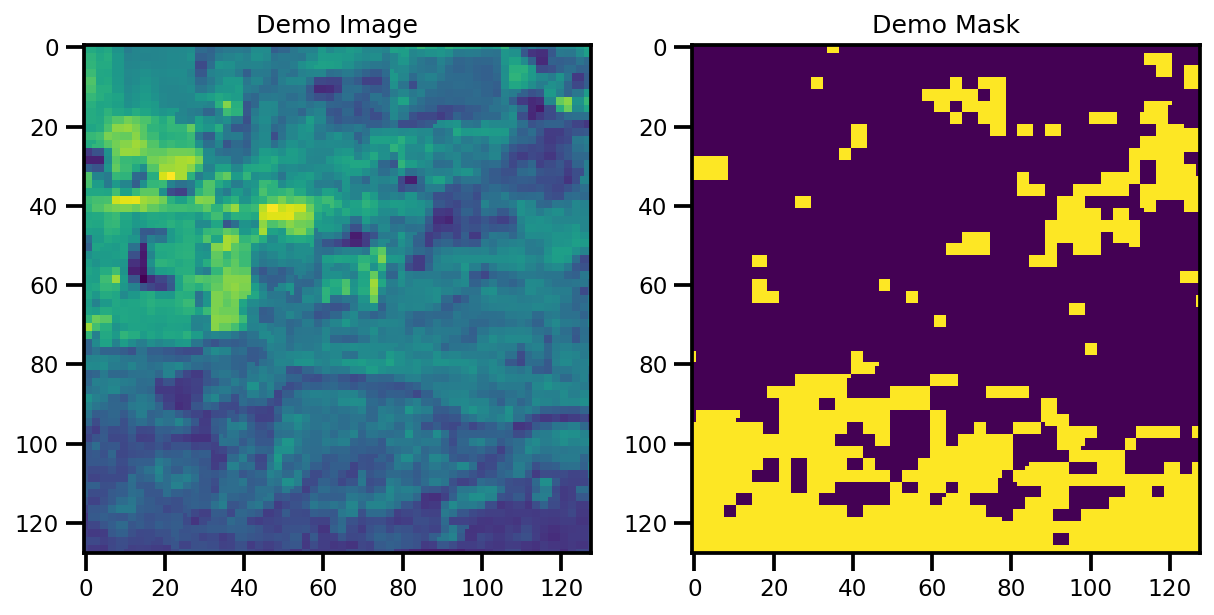

In [14]:
transform_scaling = transformations.ShiftScaleRotate(shift_limit=2, scale_limit=2, rotate_limit=2)
transform_channeljitter= transformations.PerChannel(
    transforms=[transform_scaling]
)

mega_transform = albumentations.Compose([
    transform_channeljitter, 
    ])

pt_ds = WorldFloodsDataset(image_files, image_prefix, gt_prefix, transforms=mega_transform)

print(f"Image (shape): {pt_ds[0]['image'].shape}")

plot_images(pt_ds[50])

#### RandomRotate90, Flip

Image (shape): (13, 128, 128)
(128, 128, 13) (128, 128, 1)


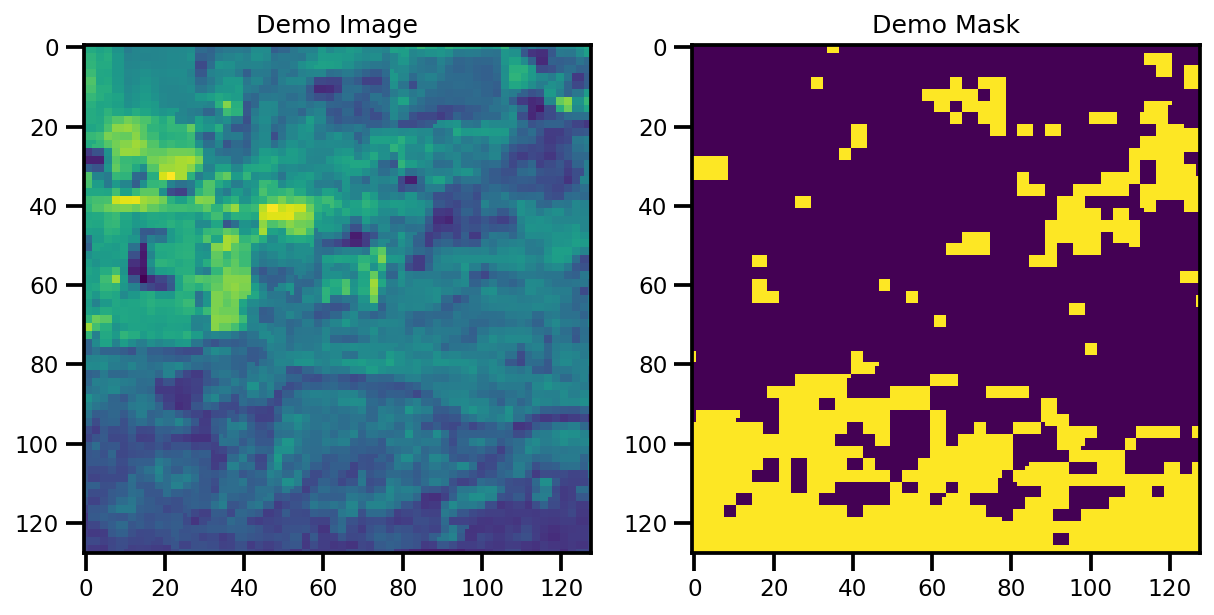

In [15]:
transform_flip = transformations.Flip(p=0.0)
transform_rr90 = transformations.RandomRotate90(p=0.0)

mega_transform = albumentations.Compose([
    transform_flip, 
    transform_rr90,
    ])

pt_ds = WorldFloodsDataset(image_files, image_prefix, gt_prefix, transforms=mega_transform)

print(f"Image (shape): {pt_ds[0]['image'].shape}")

plot_images(pt_ds[50])

#### Motion Blur

Image (shape): (13, 128, 128)
(128, 128, 13) (128, 128, 1)


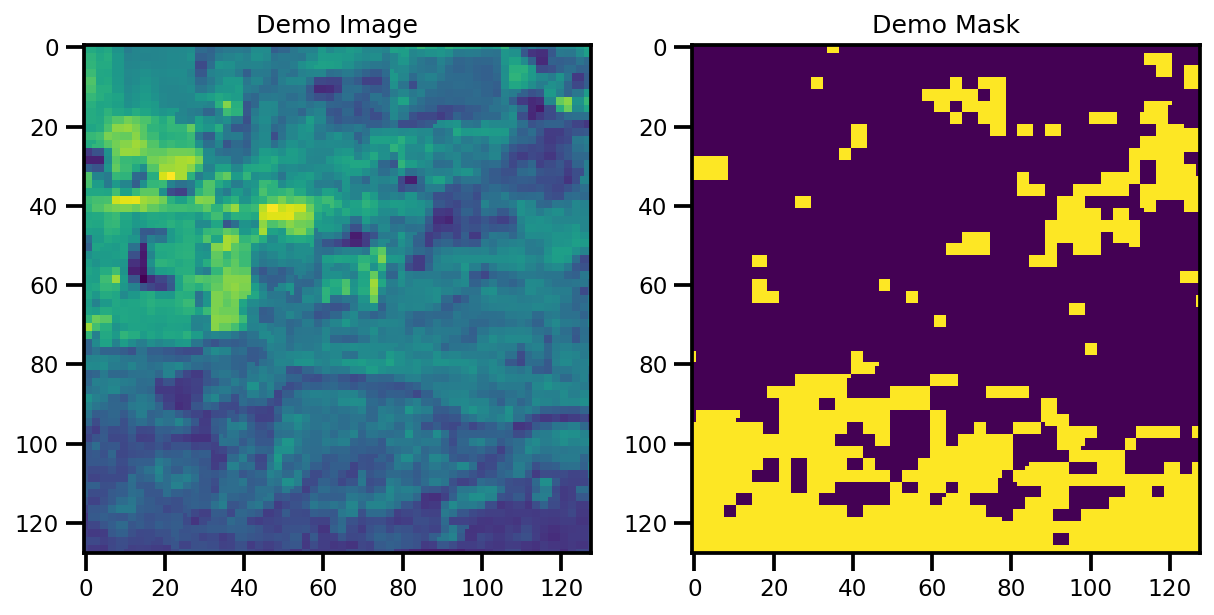

In [16]:
transform_motionblur = transformations.MotionBlur(10)

mega_transform = albumentations.Compose([
    transform_motionblur, 

    ])

pt_ds = WorldFloodsDataset(image_files, image_prefix, gt_prefix, transforms=mega_transform)

print(f"Image (shape): {pt_ds[0]['image'].shape}")

plot_images(pt_ds[50])

#### GaussNoise

Image (shape): (13, 128, 128)
12.0 3946.0
(128, 128, 13) (128, 128, 1)


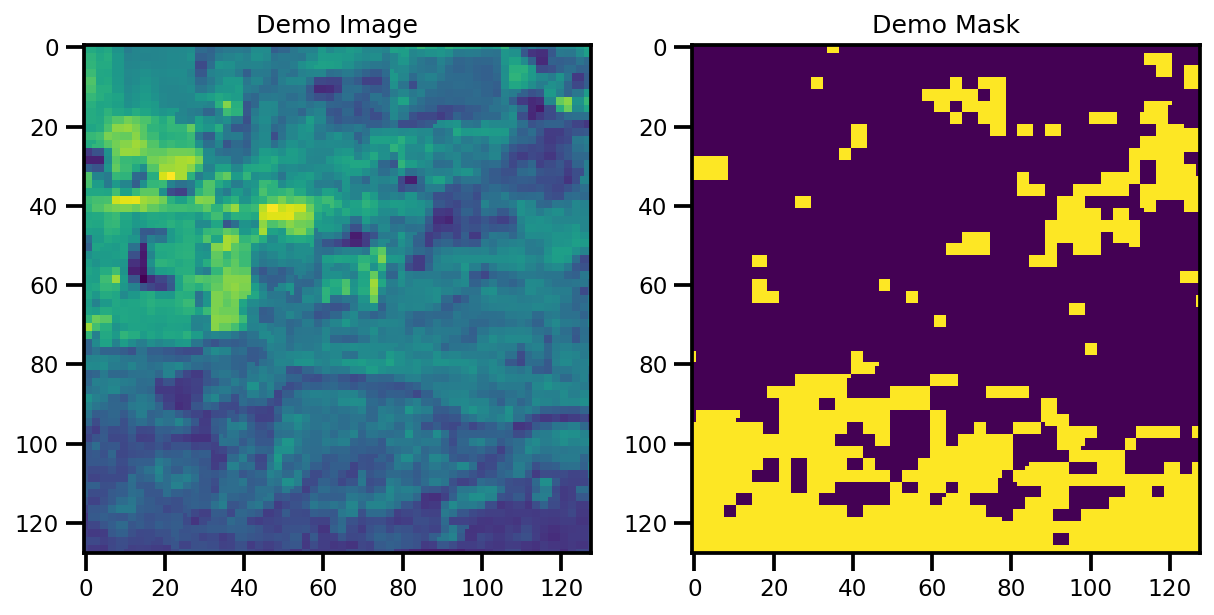

In [17]:
transform_gaussnoise = transformations.GaussNoise(var_limit=(1e-6, 1e-3), mean=0.0, p=0.0)

mega_transform = albumentations.Compose([
    transform_gaussnoise, 

    ])

pt_ds = WorldFloodsDataset(image_files, image_prefix, gt_prefix, transforms=mega_transform)

print(f"Image (shape): {pt_ds[0]['image'].shape}")
print(pt_ds[50]["image"].min(), pt_ds[50]["image"].max())
plot_images(pt_ds[50])

#### ReSize

Image (shape): (13, 32, 32)
(32, 32, 13) (128, 128, 1)


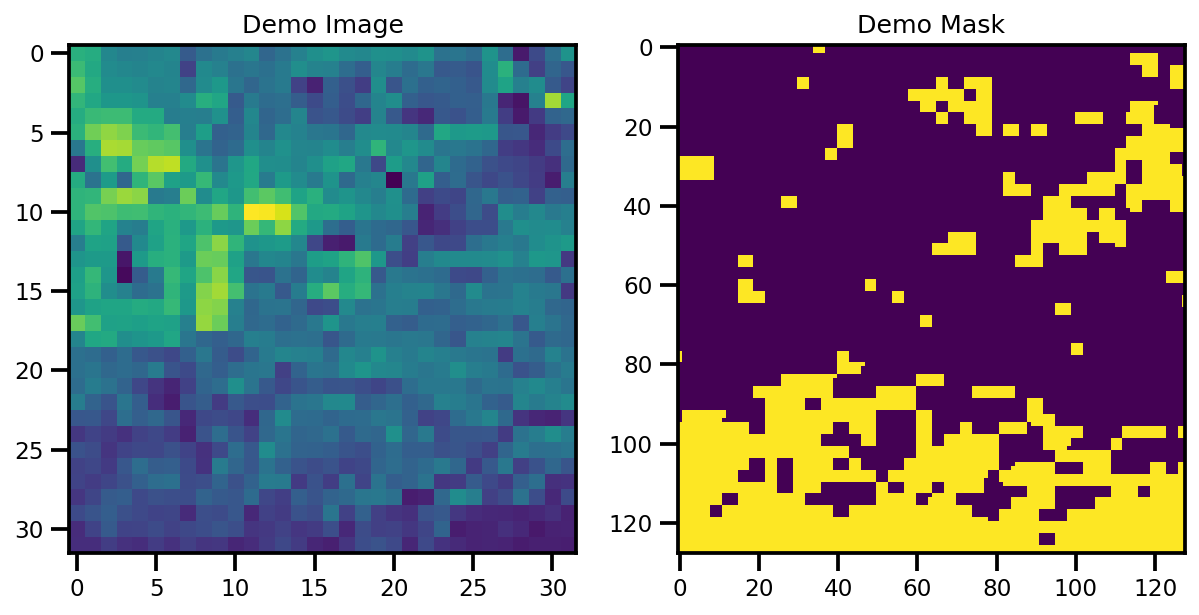

In [18]:
transform_invpermutechannels = transformations.InversePermuteChannels()
transform_resize = transformations.ResizeFactor(4)
transform_permutechannels = transformations.PermuteChannels()

mega_transform = albumentations.Compose([
    transform_invpermutechannels, 
    transform_resize,
    transform_permutechannels
    ])

pt_ds = WorldFloodsDataset(image_files, image_prefix, gt_prefix, transforms=mega_transform)

print(f"Image (shape): {pt_ds[0]['image'].shape}")

plot_images(pt_ds[50])

--------

## Stacking All Transforms Together!

In [19]:
# Stacked Transforms
tranform_permute = transformations.PermuteChannels()
tranform_toTensor = transformations.ToTensor()
tranform_oneHotEncoding = transformations.OneHotEncoding(num_classes=3)

mega_transform = transformations.Compose([
    tranform_permute, 
    tranform_toTensor, 
    tranform_oneHotEncoding,
    ])

pt_ds = WorldFloodsDataset(image_files, image_prefix, gt_prefix, transforms=mega_transform)

## Config Files

In [20]:
config_file = str(Path(root).joinpath("src/preprocess/worldfloods/demo_params.json"))



with open(config_file, "r") as f:
    config = json.load(f)

In [21]:
!cat $config_file

{
    "model_version": "baseline",
    "num_classes": 3,
    "resizefactor": {
        "downsampling_factor": 3,
        "p": 1.0
    },
    "normalize": true,
    "shiftscalerotate": {
        "shift_limit": 0.001,
        "scale_limit": 0.01,
        "rotate_limit": 0.01,
        "p": 0.5
    },
    "gaussnoise": {
        "var_limit_lower": 1e-6,
        "var_limit_upper": 1e-3,
        "p": 0.2
    },
    "motionblur": {
        "blur_limit": 7,
        "always_apply": false
    },
    "totensor": true,
    "use_channels": "all"
}

In [22]:
from src.preprocess.transformations import transforms_generator

mega_transform = transforms_generator(config)

pt_ds = WorldFloodsDataset(image_files, image_prefix, gt_prefix, transforms=mega_transform)


## Analysis of changes

So again, the corner plot comes into play. We can do some analysis post-transformations about what really happened with the images. The example corner plot comes into play again so that we can see how the distributions of the channels have changed wrt to the data augmentations. This is also quite nice for future augmentations during the testing phase as well.

In [23]:
pt_ds[50]["image"].shape

torch.Size([13, 43, 43])

(3, 43, 43)


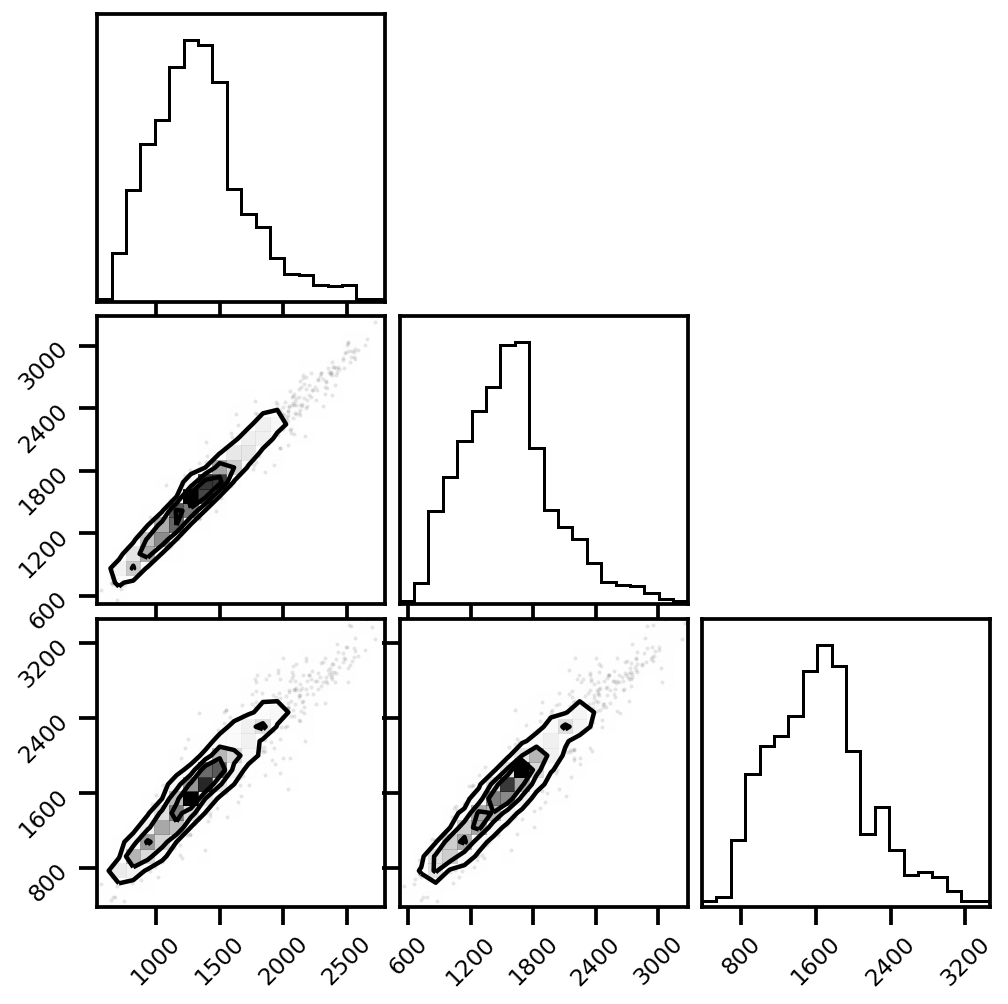

In [24]:
import corner

t = pt_ds[50]["image"][5:8].numpy()
print(t.shape)
t = reshape_as_image(t).reshape(t.shape[1]*t.shape[2], t.shape[0])

figure = corner.corner(t)